## Оценка и улучшение качества модели

In [69]:
import mglearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.datasets import make_blobs, load_iris, load_digits
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, ShuffleSplit, GroupKFold
from sklearn.ensemble import RandomForestClassifier

### Перекрестная проверка

Перекрестная проверка представляет собой статистический метод оценки обобщающей способности, который является более устойчивым и основательным, чем разбиение данных на обучающий и тестовый набор. Часто используемый вариант перекрестной проверки - k-блочная кросс-проверка, в которой k - это задаваемое пользователем число (как правило, 5 или 10). При выполнение пяти блочной перекрестной проверки, данные разбиваются на 5 блоков, схематично выглядит так: первый блок тестовый, 2-5 выполняют роль обучающего набора. 2 блок тестовый 1 и 3-5 обучающий набор и тд. Процесс показан ниже.

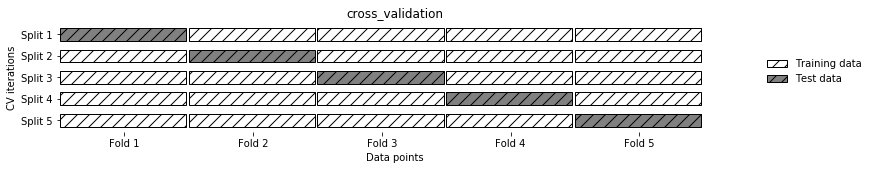

In [3]:
mglearn.plots.plot_cross_validation()

<h3 style="color: green">Перекрестная проверка в библиотеке scikit-learn</h3>

In [13]:
# реализуем проверку на наборе iris с логистической регрессии
iris = load_iris()
logreg = LogisticRegression(solver='liblinear', multi_class='auto')

scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
print("Значения правильности перекрестной проверки: {}".format(scores))

Значения правильности перекрестной проверки: [0.96078431 0.92156863 0.95833333]


In [14]:
# выведим среднее значение
print("Средняя правильность перекрестной проверки: {:.2f}".format(scores.mean()))

Средняя правильность перекрестной проверки: 0.95


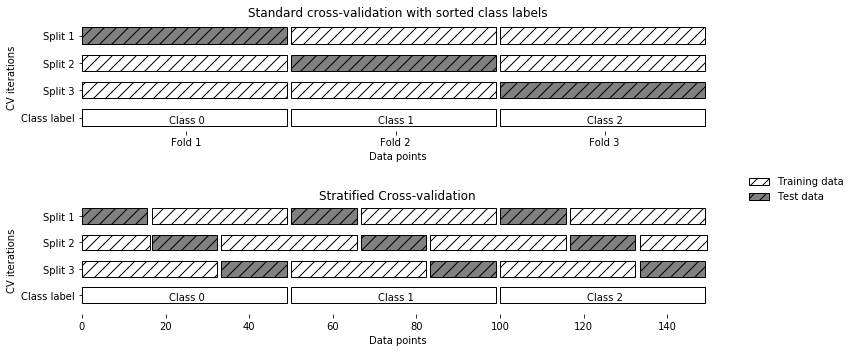

In [21]:
# стратифицированная k-блочная перекрестная проверка
# применяется когда в данных имеется несколько классов,
# к примеру в iris.target имеется 3 вида класса
mglearn.plots.plot_stratified_cross_validation()

<h4 style="color: red">Больше контроля над перекрестной проверкой</h4>

In [24]:
# Допустим хотим применить k-блочну перекрестную проверку к классифицированному набору данных,
# чтобы воспроизвести чьи-то результаты
kfold = KFold(n_splits=5)
# затем передадим объект генератора разбиения kfold в качестве параметра
print("Значения правильности перекрестной проверки:\n {}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Значения правильности перекрестной проверки:
 [1.         0.93333333 0.43333333 0.96666667 0.43333333]


In [26]:
# таким образом, использование трёхблочной (нестратифицированной) перекрестной проверки
# для iris является плохой
kfold = KFold(n_splits=3)
print("Значения правильности перекрестной проверки:\n {}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Значения правильности перекрестной проверки:
 [0. 0. 0.]


In [27]:
# можем вместо стратифицированной проверки, премешать данный, передав генератору shuffle=True
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Значение правильности перекрестной проверки:\n {}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Значение правильности перекрестной проверки:
 [0.9  0.96 0.96]


<h4 style="color: red">Перекрестная проверка с исключением по одному (leave-one-out)</h4>

Можно представить в виде k-блочной перекрестной проверки, в которой каждый блок представляет собой отдельный пример. Этот вид проверки занимает много времени особенно на больших наборах данных.

In [29]:
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Количество итераций cv: ", len(scores))
print("Средняя правильность: {:.2f}".format(scores.mean()))

Количество итераций cv:  150
Средняя правильность: 0.95


<h4 style="color: red">Перекрестная проверка со случайными перестановками при разбиении (shuffle-split cross-validation)</h4>

В этом виде проверки каждое разбиение выбирает для обучающего набора количество точек, определяемое параметром train_size, а для тестового набора test_size.

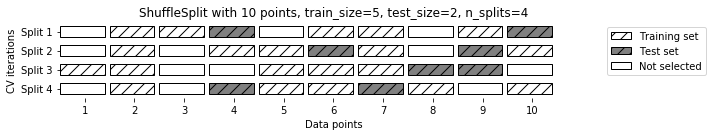

In [34]:
mglearn.plots.plot_shuffle_split()

In [43]:
# приведенный ниже код, 10 раз разбивает данные на 50% обучающий набор и 50% на тестовый набор
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)

print("Значения правильности перекрестной проверки:\n {}".format(scores))

Значения правильности перекрестной проверки:
 [1.         0.85333333 0.98666667 0.88       0.89333333 0.92
 0.98666667 0.89333333 0.92       0.97333333]


<h4 style="color: red">Перекрестная проверка с использованием групп</h4>

описывать слишком много смотри стр 329-330

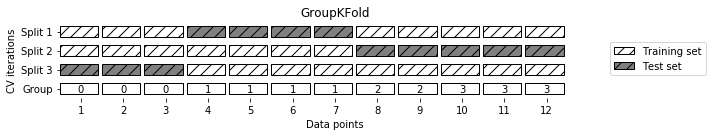

In [47]:
mglearn.plots.plot_group_kfold()

In [59]:
# создаем синтетический набор данных
X, y = make_blobs(n_samples=12, random_state=0)
# предположим, что первые три примера относятся к одной и той же
# группе, затем - следующие четыре и т.д.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Значения правильности перекрестной проверки:\n {}".format(scores))

Значения правильности перекрестной проверки:
 [0.75       0.8        0.66666667]


### Решетчатый поиск (grid search)

описывать слишком много смотри стр 330-331

<h3 style="color: green">Простой решетчатый поиск</h3>

In [73]:
# реализация наивного решетчатого поиска
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Размер обучающего набора: {} размер тестового набора: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # для каждой комбинации параметров обучаем SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # оцениваем качество SVC на тестовом наборе
        score = svm.score(X_test, y_test)
        # если получаем наилучшее значение правильности, сохраняем значения и параметры
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma': gamma}
            
print("Наилучшее значение правильности: {:.2f}".format(best_score))
print("Наилучшее значение параметров: {}".format(best_parameters))

Размер обучающего набора: 112 размер тестового набора: 38
Наилучшее значение правильности: 0.97
Наилучшее значение параметров: {'C': 100, 'gamma': 0.001}


<h3 style="color: green">Опасность переобучения параметров и проверочный набор данных</h3>

Выше мы получили правильность модели 97%. Однако это в корне может быть неверно, тк данные проверялись на тестовом наборе. А что если добавятся новые данные? Тогда результат будет иной. Для этого данные разабьём на три составляющих: тренировочный, обучающий и тестовый.

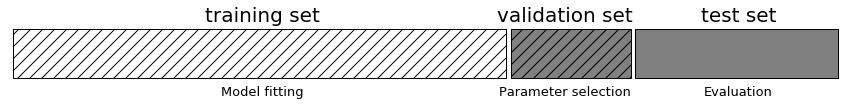

In [75]:
mglearn.plots.plot_threefold_split()

In [79]:
# разбиваем данные на обучающий+проверочный и тестовый набор
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# разбиваем обучающий+проверочный набор на обучающий и проверочный набор
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Размер обечающего набора: {} размер проверочного набора: {} \
      размер тестового набора: {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # для каждой комбинации параметров обучаем SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # оцениваем качество SVC на тестовом наборе
        score = svm.score(X_valid, y_valid)
        # если получаем наилучшее значение правильности, сохраняем значения и параметры
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma': gamma}
# заново строим модель на наборе, полученном в результате объединения
# обучающих и проверочных данных, оцениваем качество модели на тестовом наборе
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Лучшее значение правильности на проверочном наборе: {:.2f}".format(best_score))
print("Лучшее значение параметров: ", best_parameters)
print("Правильность на тестовом наборе с наилучшими параметрами: {:.2f}".format(test_score))

Размер обечающего набора: 84 размер проверочного набора: 28       размер тестового набора: 38

Лучшее значение правильности на проверочном наборе: 0.96
Лучшее значение параметров:  {'C': 10, 'gamma': 0.001}
Правильность на тестовом наборе с наилучшими параметрами: 0.92


И так, можно сделать вывод, что правильность классификации новых данных составляет 92%, а не 97%, как было ранее!

<h3 style="color: green">Решетчатый поиск с перекрестной проверкой</h3>

In [97]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        # выполняем перекрестную проверку
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma': gamma}
# заново строим модель на наборе, полученном в результате объединения обучающих и проверочных данных
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

C:\Users\Azamind\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


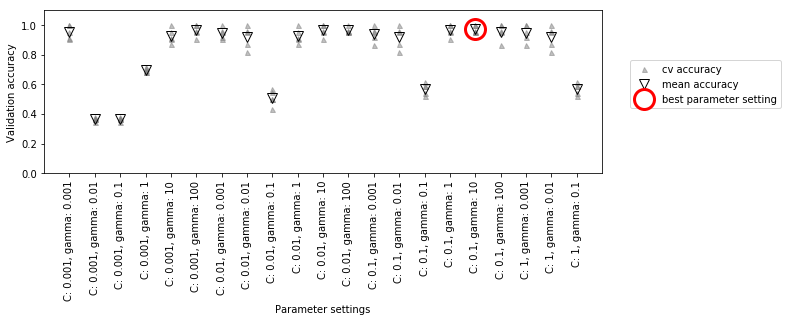

In [91]:
# результаты решетчатого поиска с перекрестной проверкой
mglearn.plots.plot_cross_val_selection()

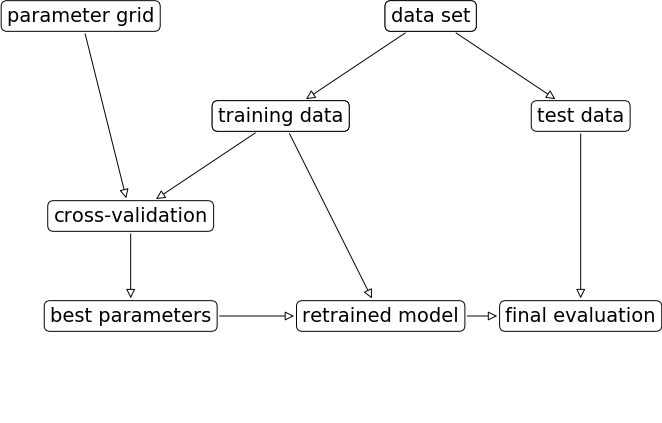

In [98]:
# процесс отбора параметров и оценки модели класса GridSearchCV
mglearn.plots.plot_grid_search_overview()

In [101]:
# в sklearn уже есть готовый класс для тестирования решетчатого поиска GridSearchCV
# для начало подготовим проверяющие параметры
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print('Сетка параметров:\n{}'.format(param_grid))

Сетка параметров:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [107]:
# в класс передадим param_grid и стратегию перекрестной проверки
# допустим, пятиблочную стратифицированную перекрестную проверку
grid_search = GridSearchCV(SVC(), param_grid, cv=5, iid=True)
# разделим на обучающий и тестовый набор, чтобы избежать переобучение параметров
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

Созданный объект grid_search аналогичен классификатору, можем вызывать fit, predict и score. Однако, когда вызовем его метод fit, он запускает перекрестную проверку для каждой комбинации параметров, указанных в сетке param_grid

In [109]:
grid_search.fit(X_train, y_train)
print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))

Правильность на тестовом наборе: 0.97


In [111]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидации правильности: {:.2f}".format(grid_search.best_score_))

Наилучшие значения параметров: {'C': 100, 'gamma': 0.01}
Наилучшее значение кросс-валидации правильности: 0.97


В ряде случаев необходимо будет ознакомиться с полученной моделью, например взглянуть на коэф. или важности признаков, это можно сделать с помощью атрибута best_estimator_

In [113]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


<h4 style="color: red">Анализ результатов перекрестной проверки</h4>

In [118]:
# визуализируем результаты перекрестной проверки с помощью атрибута cv_results_
# легче это сделать с pandas
# преобразуем в DataFrame
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001199,0.000399,0.000400,0.000490,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000800,0.000400,0.000400,0.000490,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000997,0.000008,0.000200,0.000400,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.001010,0.000040,0.000584,0.000478,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.001000,0.000005,0.000000,0.000000,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


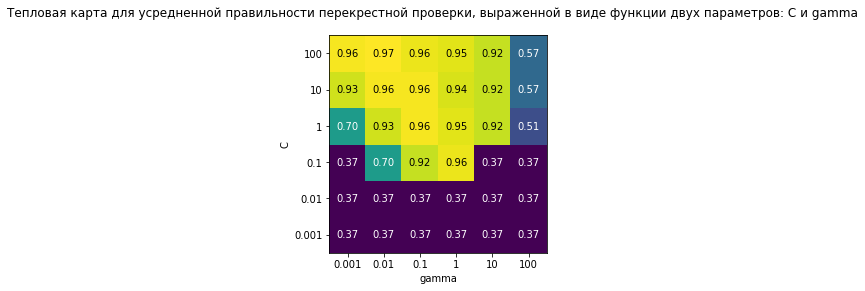

In [128]:
scores = np.array(results.mean_test_score).reshape(6, 6)
# строим теплокарту средних значений правильности перекрестной проверки
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], 
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
plt.suptitle('Тепловая карта для усредненной правильности перекрестной проверки, выраженной в виде функции двух параметров: C и gamma')
plt.show()

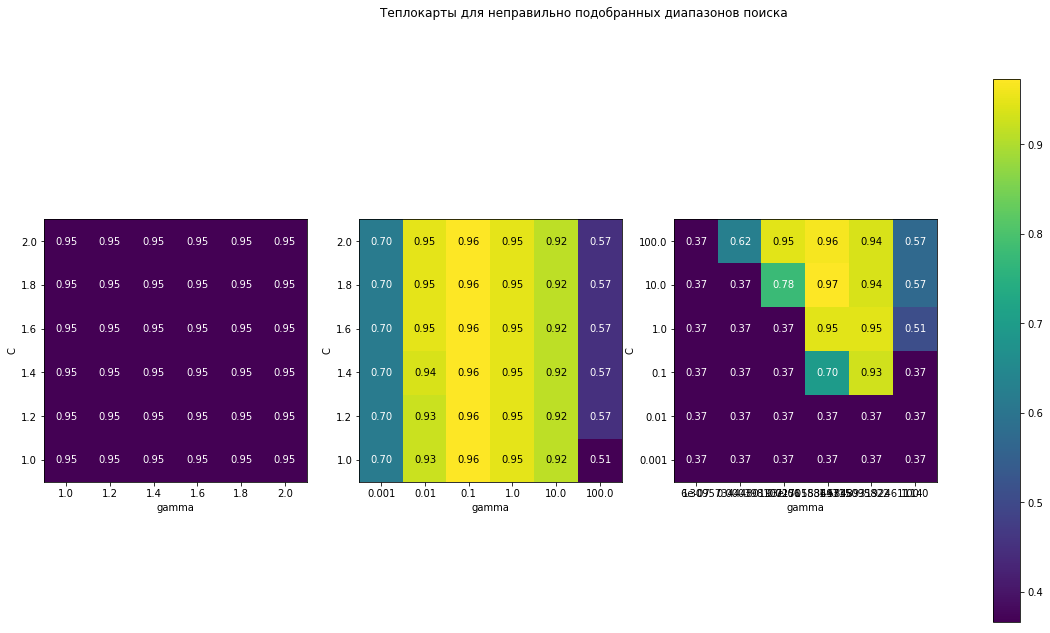

In [134]:
# идет достаточно большой разброс правильности и неправильности параметров от 37% перепрыгивает до 96%
# реализуем теплокарту для неправильно подобранных диапазонов поиска, для углубления видения
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
param_grid_linear = {'C': np.linspace(1,2,6), 'gamma': np.linspace(1,2,6)}
param_grid_one_log = {'C': np.linspace(1,2,6), 'gamma': np.logspace(-3,2,6)}
param_grid_range = {'C': np.logspace(-3,2,6), 'gamma': np.logspace(-7,2,6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, iid=True)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    
    # строим тепловую карту средних значений правильности перекрестной проверки
    score_image = mglearn.tools.heatmap(scores, xlabel='gamma', ylabel='C',
                                        xticklabels=param_grid['gamma'],
                                        yticklabels=param_grid['C'], cmap='viridis', ax=ax)

plt.colorbar(score_image, ax=axes.tolist())
plt.suptitle('Теплокарты для неправильно подобранных диапазонов поиска')
plt.show()

<h4 style="color: red">Экономичный решетчатый поиск</h4>

Не всегда нужно использовать параметры C & gamma. К примеру SVC классе когда параметр kernel='linear', модель является линейной и использует только С. В случае если kernel='rbf', используется и С и gamma.

In [137]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]
              }]
print("List of grid: \n{}".format(param_grid))

List of grid: 
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [138]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, iid=True)
grid_search.fit(X_train, y_train)
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее занчение кросс-валидации правильности: {:.2f}".format(grid_search.best_score_))

Наилучшие значения параметров: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Наилучшее занчение кросс-валидации правильности: 0.97


In [142]:
results = pd.DataFrame(grid_search.cv_results_)
# выводим транспонированную таблицу для лучшего отображения на странице
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00101686,0.000977373,0.00102854,0.000997353,0.00100274,0.00140591,0.000782251,0.000800705,0.00142226,0.000844908,...,0.000379324,0.0006001,0.000995827,0.0015995,0.000634813,0.000584269,0.000606108,0.00019536,0.000400352,0.000399876
std_fit_time,3.03259e-05,3.39392e-05,3.84347e-05,1.01505e-05,4.59202e-06,0.000490228,0.000392882,0.000400354,0.000474487,0.000424046,...,0.000465416,0.00048998,1.69699e-05,0.000480032,0.000519056,0.000477055,0.000495258,0.00039072,0.000490332,0.000489746
mean_score_time,0.000602245,0.000397825,0.000597239,0,0,0.00059824,0.000399065,0.000600004,0.0007792,0.000402689,...,0.000401163,0.00020051,0.000394726,0.000220966,0.000393724,0.000405169,0.000194359,0.000611401,0.000200319,0.000200033
std_score_time,0.000491733,0.000487281,0.000487775,0,0,0.000488489,0.000488756,0.000489902,0.000391704,0.000497079,...,0.000491323,0.00040102,0.000483504,0.000441933,0.000482304,0.000496294,0.000388718,0.000499257,0.000400639,0.000400066
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.521739,0.347826,0.826087,0.913043,0.956522,1,1


### Метрики качества модели и их вычисление

<h3 style="color: green">Метрики для бинарной классификации</h3>

 <h4 style="color: red">Несблансированные наборы данных</h4>

In [6]:
# классификация девятка или нет
digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [8]:
# воспользуемся DummyClassifier для определения "не девятка"
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Уникальность спрогнозированные метрики: {}".format(np.unique(pred_most_frequent)))
print("Правильность на тестовом наборе: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Уникальность спрогнозированные метрики: [False]
Правильность на тестовом наборе: 0.90


Получили 90% без какого-либо обучения. Это вполне правильно прогнозирую всего 1 класс. Ниже сравним результаты с реальной моделью 

In [9]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Правильность на тестовом наборе {:.2f}".format(tree.score(X_test, y_test)))

Правильность на тестовом наборе 0.92


Получили результат намного лучше, чем DummyClassifier. Это может означать что DecisionTreeClassifier возможно был неправильно использован. На всякий проверим LogReg

In [13]:
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("Правильность на dummy: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=.1, solver='liblinear').fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("Правильность logreg: {:.2f}".format(logreg.score(X_test, y_test)))

Правильность на dummy: 0.80
Правильность logreg: 0.98


 <h4 style="color: red">Матрица ошибок</h4>

Одним из наиболее развернутых способов, оценивающее качество бинарной классификации, является матрица ошибок.

In [17]:
confusion = confusion_matrix(y_test, pred_logreg)
print("Матрица ошибок: \n{}".format(confusion))

Матрица ошибок: 
[[401   2]
 [  8  39]]


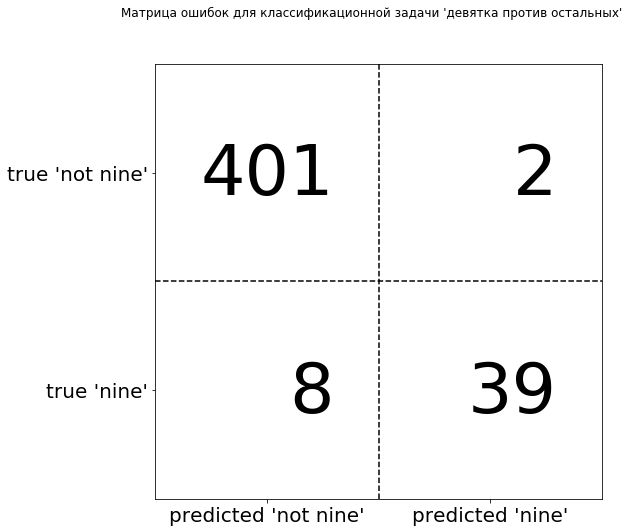

In [19]:
mglearn.plots.plot_confusion_matrix_illustration()
plt.suptitle("Матрица ошибок для классификационной задачи 'девятка против остальных'")
plt.show()

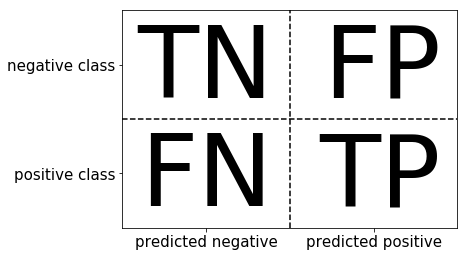

In [21]:
# TN - true negative - истинно отрицательный
# FN - false negative - ложно отрицательный
# FP - false positive - ложно положительный
# TP - true positive - истинно положительный
mglearn.plots.plot_binary_confusion_matrix()

In [22]:
# сравним ранее использованные модели с помощью матрицей ошибок
print("Наиболее часто встречающийся класс:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\n Дамми-модель:")
print(confusion_matrix(y_test, pred_dummy))
print("\n Дерево решений:")
print(confusion_matrix(y_test, pred_tree))
print("\n Логистическая регрессия")
print(confusion_matrix(y_test, pred_logreg))

Наиболее часто встречающийся класс:
[[403   0]
 [ 47   0]]

 Дамми-модель:
[[365  38]
 [ 42   5]]

 Дерево решений:
[[390  13]
 [ 24  23]]

 Логистическая регрессия
[[401   2]
 [  8  39]]


In [26]:
# стр 359 - 361 подробное объяснение
# f1 мера учитывающая точность и полноту
# класс девятка положительный = True, не девятка = False
print("f1-мера наибольшая частота: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1-мер дамми: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1-мер дерево: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1-мер логистическая регрессия: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1-мера наибольшая частота: 0.00
f1-мер дамми: 0.11
f1-мер дерево: 0.55
f1-мер логистическая регрессия: 0.89


In [29]:
# развернутый отчёт о точности, полноте и f-мере
print(classification_report(y_test, pred_most_frequent, target_names=["не девятка", "девятка"]))

              precision    recall  f1-score   support

  не девятка       0.90      1.00      0.94       403
     девятка       0.00      0.00      0.00        47

   micro avg       0.90      0.90      0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



In [30]:
# logistic regression
print(classification_report(y_test, pred_logreg, target_names=["не девятка", "девятка"]))

              precision    recall  f1-score   support

  не девятка       0.98      1.00      0.99       403
     девятка       0.95      0.83      0.89        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



<h4 style="color: red">Принимаем во внимание неопределенность</h4>

Ниже приведен пример несбалансированной бинарной классификации: 400 точек данных в отрицательном классе и 50 в положительном. Модель обучаем на ядерном SVM, а также выводим справа график обучающих данных, показывающие значения решиющей функции в виде теплокарты. В центре графика видим черную окружность, которая соответствует пороговому значению метода decision_function, равному нулю.  Точки внутри классифицируются как положительный, а вне отрицательный класс.

In [4]:
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

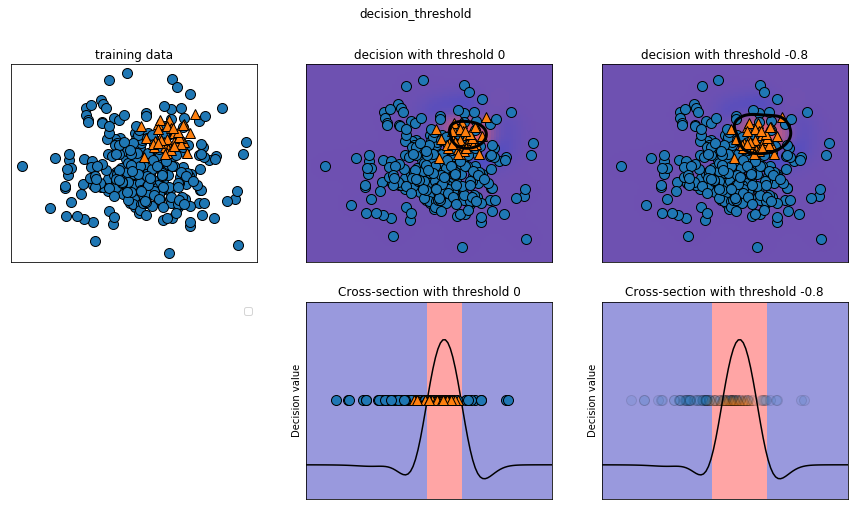

In [5]:
mglearn.plots.plot_decision_threshold()

In [6]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

   micro avg       0.88      0.88      0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



<h4 style="color: red">Кривые точности-полноты и ROC-кривые (precision-recal curve)</h4>

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

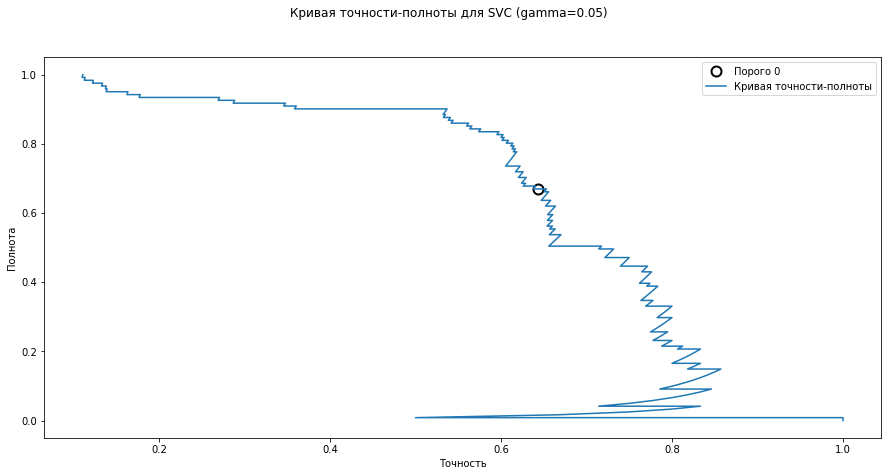

In [25]:
# функция precisio_recall_curve возвращает список значений точности и полноты для всех
# возможных пороговых значений в отсортированном ввиде.
# построим кривую ниже
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
# находим ближайший к нулю порог
close_zero = np.argmin(np.abs(thresholds))
plt.figure(figsize=(15, 7))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="Порого 0", fillstyle="none", c="k", mew=2)
plt.plot(precision, recall, label="Кривая точности-полноты")
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.suptitle('Кривая точности-полноты для SVC (gamma=0.05)')
plt.show()

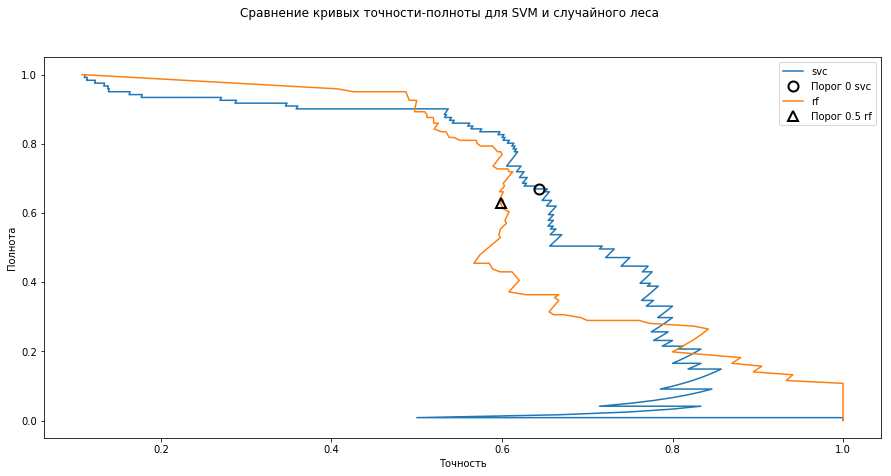

In [28]:
# сравними SVC с случаными лесами  RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# в классе RandomForestClassifier есть метод predic_proba
# но нет метода decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(15, 7))
plt.plot(precision, recall, label="svc")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="Порог 0 svc", fillstyle="none", c="k", mew=2)
plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', markersize=10, label="Порог 0.5 rf", fillstyle="none", c="k", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.suptitle("Сравнение кривых точности-полноты для SVM и случайного леса")
plt.show()

In [29]:
# f1-мера учитывает только одну точку на кривой точности-полноты, определяемую порогом по умолчанию
print("f1-мера random forest: {:.3f}".format(f1_score(y_test, rf.predict(X_test))))
print("f1-мера svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1-мера random forest: 0.610
f1-мера svc: 0.656


In [31]:
# одним из способов подытожить инфу кроивой заключается в вычислении интеграла или площади под кривой точности-полноты
# он также называется как метод средней точности (average precision)
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print("Средняя точность random forest: {:.3f}".format(ap_rf))
print("Средняя точность svc: {:.3f}".format(ap_svc))

Средняя точность random forest: 0.660
Средняя точность svc: 0.666


<h4 style="color: red">Рабочая характеристика приемника (ROC) и AUC</h4>

Ещё один инструмент,который обычно используется для анализа поведения классификаторов при различных пороговых значениях - *это кривая рабочей характеристики приемника* (*receive operating characteristics curve*) или кратко ROC-кривая. ROC-кривая вместо точности и полноты показывает долю ложно положительных примеров (false positive rate - FPR) в сравнении с долей истинно положительных примеров (true positive rate). Вспомним, что доля истинно положительных примеров - это просто ещё одно название полноты, тогда как доля ложно положительных примеров - это доля ложно положительных примеров от общего количества отрицательных примеров. 

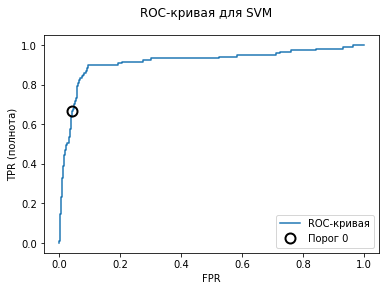

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC-кривая")
plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
# находим пороговое значение ближайшее к нулю
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="Порог 0", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)
plt.suptitle("ROC-кривая для SVM")
plt.show()

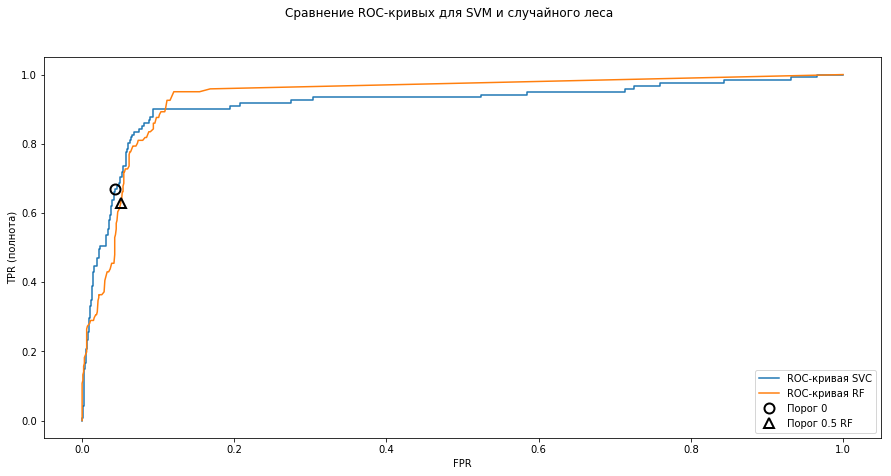

In [35]:
# сравнение RandomForest и SVM моделей
plt.figure(figsize=(15, 7))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC-кривая SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC-кривая RF")

plt.xlabel("FPR")
plt.ylabel("TPR (полнота)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="Порог 0", fillstyle="none", c="k", mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10, label="Порог 0.5 RF", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)
plt.suptitle("Сравнение ROC-кривых для SVM и случайного леса")
plt.show()

In [38]:
# вычислим площадь под кривой ROC c помощью функции roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print("AUC для случайного леса: {:.3f}".format(rf_auc))
print("AUC для SVC: {:.3f}".format(svc_auc))

AUC для случайного леса: 0.937
AUC для SVC: 0.916


gamma = 1.00 правильность = 0.90 AUC = 0.50
gamma = 0.05 правильность = 0.90 AUC = 1.00
gamma = 0.01 правильность = 0.90 AUC = 1.00


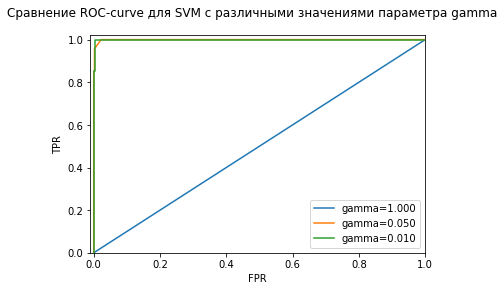

In [44]:
# Классифицируем данные в наборе digits девятки и остальные цифры.
digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)
plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print("gamma = {:.2f} правильность = {:.2f} AUC = {:.2f}".format(gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.suptitle("Сравнение ROC-curve для SVM с различными значениями параметра gamma")
plt.show()

<h3 style="color: green">Метрики для мультиклассовой классификации</h3>

стр 377 подробно всё написано, читай!

In [52]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
lr = LogisticRegression(multi_class="auto", solver="liblinear").fit(X_train, y_train)
pred = lr.predict(X_test)
print("Правильность: {:.3f}".format(accuracy_score(y_test, pred)))

print("Матрица ошибок: \n{}".format(confusion_matrix(y_test, pred)))

Правильность: 0.953
Матрица ошибок: 
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


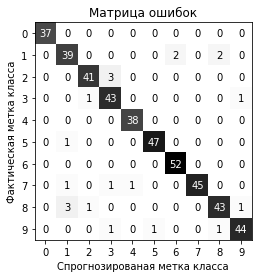

In [54]:
# Матрица ошибок для десятиклассовой задачи распознавания рукописаных цифр
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred),
    xlabel="Спрогнозированая метка класса",
    ylabel="Фактическая метка класса",
    xticklabels=digits.target_names,
    yticklabels=digits.target_names,
    cmap=plt.cm.gray_r, fmt="%d"
)
plt.title("Матрица ошибок")
plt.gca().invert_yaxis()

In [55]:
# С помощью функции classification_report можем вычислить точность, полноту и f1-метку для каждого класса
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



In [56]:
print("Микроусредненная f1-мера: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Макроусредненная f1-мера: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Микроусредненная f1-мера: 0.953
Макроусредненная f1-мера: 0.954


<h3 style="color: green">Использование метрик оценки для отбора модели</h3>

In [67]:
# метрика качества классификационной модели по умолчанию - правильность
print("Метрика качества по умолчанию: {}".format(cross_val_score(SVC(gamma='auto'), digits.data, digits.target == 9, cv=5)))
# значение параметра scoring="accuracy" не меняет результатов
explicit_accuracy = cross_val_score(SVC(gamma='auto'), digits.data, digits.target == 9, scoring="accuracy", cv=5)
print("Метрика качество явно заданная правильность: {}".format(explicit_accuracy))
roc_auc = cross_val_score(SVC(gamma='auto'), digits.data, digits.target == 9, scoring="roc_auc", cv=5)
print("Метрика качества AUC: {}".format(roc_auc))

Метрика качества по умолчанию: [0.9        0.9        0.89972145 0.89972145 0.89972145]
Метрика качество явно заданная правильность: [0.9        0.9        0.89972145 0.89972145 0.89972145]
Метрика качества AUC: [0.99674211 0.99725652 0.99552804 0.99836601 0.99165807]


In [71]:
res = cross_validate(SVC(gamma='auto'), digits.data, digits.target == 9,
                     scoring=["accuracy", "roc_auc", "recall_macro"],
                     return_train_score=True, cv=5)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_recall_macro,train_recall_macro
0,0.288128,0.163158,0.900000,1.0,0.996742,1.0,0.5,1.0
1,0.313145,0.166081,0.900000,1.0,0.997257,1.0,0.5,1.0
2,0.272130,0.163188,0.899721,1.0,0.995528,1.0,0.5,1.0
3,0.357173,0.201098,0.899721,1.0,0.998366,1.0,0.5,1.0
4,0.274035,0.276126,0.899721,1.0,0.991658,1.0,0.5,1.0


In [75]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state=0)

# зададим не самую удачную сетку параметров для иллюстрации
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# используем метрику по умолчанию, т.е. правильность
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Решетчатый поиск с использованием правильности")
print("Наилучшие параметры:", grid.best_params_)
print("Наилучшие значения перекрестной проверки (правильность) : {:.3f}".format(grid.best_score_))
print("AUC на тестовом наборе: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Правильность на тестовом наборе: {:.3f}".format(grid.score(X_test, y_test)))

Решетчатый поиск с использованием правильности
Наилучшие параметры: {'gamma': 0.0001}
Наилучшие значения перекрестной проверки (правильность) : 0.976
AUC на тестовом наборе: 0.992
Правильность на тестовом наборе: 0.973


In [78]:
# используем метрику качества AUC:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc", cv=5)
grid.fit(X_train, y_train)
print("\nРешетчатый поиск с использованием AUC")
print("Наилучшие параметры: ", grid.best_params_)
print("Наилучшие значения перекрестной проверки (AUC): {:.3f}".format(grid.best_score_))
print("AUC на тестовом наборе: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Правильность на тестовом наборе: {:.3f}".format(grid.score(X_test, y_test)))


Решетчатый поиск с использованием AUC
Наилучшие параметры:  {'gamma': 0.01}
Наилучшие значения перекрестной проверки (AUC): 0.998
AUC на тестовом наборе: 1.000
Правильность на тестовом наборе: 1.000


In [79]:
from sklearn.metrics import SCORERS 
print("Доступные объекты scorer:\n{}".format(sorted(SCORERS.keys())))

Доступные объекты scorer:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
